In [1]:
#IMPORT MODULES

from __future__ import print_function
import sys
import csv
import tensorflow as tf
import sklearn
import en_core_web_sm
import keras
from keras import layers
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences 
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers import Dropout, Activation
from keras.optimizers import SGD
from IPython import display
from keras.preprocessing.sequence import pad_sequences
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
from matplotlib.ticker import MaxNLocator
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import os, eli5, shap
np.set_printoptions(threshold=sys.maxsize)
from eli5.sklearn import PermutationImportance
from pdpbox import pdp

Using TensorFlow backend.


In [50]:
#avg results of top 5 performs for 2017 andd 2018 contest

pastModels=[[2017,1,.43857],[2017,2,.44981],[2017,3,.45373],[2017,4,.46100],[2017,5,.46107],[2018,1,.53194],[2018,2,.53693],[2018,3,.54013],[2018,4,.54967],[2018,5,.54987],[2019,1,.41477],[2019,2,.42012],[2019,3,.42698],[2019,4,.42788],[2019,5,.43148]]
cols=['Year','Rank','LogLoss']
pastScores=pd.DataFrame(pastModels, columns=cols)
pastMadness=[[2017,65.7,82,93,83],[2018,57,81,131,99.2],[2019,74,124,162,99.99]]
cols=['Year','avg_score','higherSeed_score','myScore','percentile_myScore']
pastMadness=pd.DataFrame(pastMadness, columns=cols)

In [51]:
tourney_training_data=pd.read_csv("tourney_game_master1.csv")
#Get Training data
tourney_training_data.dropna(inplace=True)
tourneyInputData=tourney_training_data[['Season','ATeam','BTeam','A_KP_AdjEM', 'A_KP_SOS_Adj', 'ALuck', 'Asos', 'Ats_pct', 'Aie', 'Afour', 
                                        'Amov',  'APOM', 'ASAG', 'AMOR', 'Aelo', 'Awins_top25', 'Awins_top5', 'Awin_pct', 
                                        'AAdjustD', 'AAdjustO', 'B_KP_AdjEM', 'B_KP_SOS_Adj', 
                                        'BLuck', 'Bsos', 'Bts_pct', 'Bie', 'Bfour', 'Bmov', 'BPOM', 'BSAG', 'BMOR', 'Belo', 
                                        'Bwins_top25', 'Bwins_top5', 'Bwin_pct', 'BAdjustD', 'BAdjustO', 'KP_AdjEM_diff', 'KP_SOS_Adj_diff', 
                                        'sos_diff', 'ts_pct_diff', 'ie_diff', 'four_diff', 'mov_diff',  'POM_diff', 'SAG_diff', 
                                        'MOR_diff', 'Luck_diff', 'elo_diff', 'wins_top25_diff', 'wins_top5_diff', 'AdjustO_diff', 'AdjustD_diff', 'win_pct_diff']]
  
tourneyOutputData=tourney_training_data[['Season','AWon']]
train_input=tourneyInputData[tourneyInputData['Season']<2017].reset_index(drop=True)
train_input=train_input[['A_KP_AdjEM', 'A_KP_SOS_Adj', 'ALuck', 'Asos', 'Ats_pct', 'Aie', 'Afour', 'Amov', 'APOM', 'ASAG', 'AMOR', 'Aelo', 'Awins_top25', 'Awins_top5', 'Awin_pct', 'AAdjustD', 'AAdjustO', 'B_KP_AdjEM', 'B_KP_SOS_Adj', 'BLuck', 'Bsos', 'Bts_pct', 'Bie', 'Bfour', 'Bmov', 'BPOM', 'BSAG', 'BMOR', 'Belo', 'Bwins_top25', 'Bwins_top5', 'Bwin_pct', 'BAdjustD', 'BAdjustO','KP_AdjEM_diff', 'KP_SOS_Adj_diff', 'Luck_diff', 'sos_diff', 'ts_pct_diff', 'ie_diff', 'four_diff', 'mov_diff', 'POM_diff', 'SAG_diff', 'MOR_diff',  'elo_diff', 'wins_top25_diff', 'wins_top5_diff', 'win_pct_diff','AdjustD_diff','AdjustO_diff' ]]
train_output=tourneyOutputData[tourneyOutputData['Season']<2017].reset_index(drop=True)
train_output=train_output[['AWon']]


#Get test data
test_input=tourneyInputData[tourneyInputData['Season']>2016].reset_index(drop=True)
test_input=test_input[['A_KP_AdjEM', 'A_KP_SOS_Adj', 'ALuck', 'Asos', 'Ats_pct', 'Aie', 'Afour', 'Amov', 'APOM', 'ASAG', 'AMOR', 'Aelo', 'Awins_top25', 'Awins_top5', 'Awin_pct', 'AAdjustD', 'AAdjustO', 'B_KP_AdjEM', 'B_KP_SOS_Adj', 'BLuck', 'Bsos', 'Bts_pct', 'Bie', 'Bfour', 'Bmov', 'BPOM', 'BSAG', 'BMOR', 'Belo', 'Bwins_top25', 'Bwins_top5', 'Bwin_pct', 'BAdjustD', 'BAdjustO','KP_AdjEM_diff', 'KP_SOS_Adj_diff', 'Luck_diff', 'sos_diff', 'ts_pct_diff', 'ie_diff', 'four_diff', 'mov_diff', 'POM_diff', 'SAG_diff', 'MOR_diff',  'elo_diff', 'wins_top25_diff', 'wins_top5_diff', 'win_pct_diff','AdjustD_diff','AdjustO_diff' ]]
test_output=tourneyOutputData[tourneyOutputData['Season']>2016].reset_index(drop=True)
test_output=test_output[['AWon']]


In [52]:
#Show sample of DataFrame
test_input.head(5)

,A_KP_AdjEM,A_KP_SOS_Adj,ALuck,Asos,Ats_pct,Aie,Afour,Amov,APOM,ASAG,AMOR,Aelo,Awins_top25,Awins_top5,Awin_pct,AAdjustD,AAdjustO,B_KP_AdjEM,B_KP_SOS_Adj,BLuck,Bsos,Bts_pct,Bie,Bfour,Bmov,BPOM,BSAG,BMOR,Belo,Bwins_top25,Bwins_top5,Bwin_pct,BAdjustD,BAdjustO,KP_AdjEM_diff,KP_SOS_Adj_diff,Luck_diff,sos_diff,ts_pct_diff,ie_diff,four_diff,mov_diff,POM_diff,SAG_diff,MOR_diff,elo_diff,wins_top25_diff,wins_top5_diff,win_pct_diff,AdjustD_diff,AdjustO_diff
0,23.31,7.13,0.046,16.198486,57.770923,62.607934,0.367951,10.476471,20,18,21,1564.338877,3,0,0.882353,95.1,118.4,0.04,-5.66,0.048,5.296888,57.232652,54.037998,0.358434,3.984962,173,176,156,1203.480859,0,0,0.678571,103.5,103.6,23.27,12.79,-0.002,10.901598,0.538271,8.569936,0.009518,6.491508,-153,-158,-135,360.858019,3,0,0.203782,-8.4,14.8
1,23.31,7.13,0.046,16.198486,57.770923,62.607934,0.367951,10.476471,20,18,21,1564.338877,3,0,0.882353,95.1,118.4,23.67,0.41,0.030,25.407017,60.345084,67.213811,0.371236,15.026786,14,25,26,1347.875927,0,0,0.875000,95.0,118.7,-0.36,6.72,0.016,-9.208531,-2.574161,-4.605877,-0.003284,-4.550315,6,-7,-5,216.462950,3,0,0.007353,0.1,-0.3
2,16.25,8.37,0.086,8.179100,55.557028,56.305476,0.357436,6.174118,38,37,40,1011.700036,1,0,0.735294,99.8,116.1,13.63,9.65,0.058,4.343330,54.148320,53.293282,0.351570,3.139881,53,49,34,1041.147358,2,0,0.656250,95.8,109.4,2.62,-1.28,0.028,3.835770,1.408708,3.012194,0.005866,3.034237,-15,-12,6,-29.447322,-1,0,0.079044,4.0,6.7
3,7.89,-4.52,0.063,13.497683,57.716089,61.772175,0.386777,9.066667,88,97,177,1640.635822,0,0,0.833333,102.6,110.5,24.23,13.08,0.023,10.691229,54.820036,59.018848,0.366041,7.106183,13,14,20,1024.049588,6,0,0.774194,92.9,117.1,-16.34,-17.60,0.040,2.806454,2.896053,2.753328,0.020736,1.960484,75,83,157,616.586233,-6,0,0.059140,9.7,-6.6
4,13.45,5.49,0.079,8.305611,55.716894,55.959719,0.348941,5.568182,61,55,52,982.925540,2,0,0.727273,100.7,114.2,24.23,13.08,0.023,10.691229,54.820036,59.018848,0.366041,7.106183,13,14,20,1024.049588,6,0,0.774194,92.9,117.1,-10.78,-7.59,0.056,-2.385619,0.896858,-3.059129,-0.017100,-1.538001,48,41,32,-41.124048,-4,0,-0.046921,7.8,-2.9


In [53]:
test_output.head(5)



,AWon
0,1
1,1
2,1
3,0
4,0


In [54]:
#scale data
scaler = StandardScaler()

scaler.fit(train_input) 
X_train = pd.DataFrame(scaler.transform(train_input), index=train_input.index, columns=train_input.columns)
X_test = pd.DataFrame(scaler.transform(test_input), index=test_input.index, columns=test_input.columns)
Y_train=train_output
Y_test=test_output



In [55]:
X_test.head(5)

,A_KP_AdjEM,A_KP_SOS_Adj,ALuck,Asos,Ats_pct,Aie,Afour,Amov,APOM,ASAG,AMOR,Aelo,Awins_top25,Awins_top5,Awin_pct,AAdjustD,AAdjustO,B_KP_AdjEM,B_KP_SOS_Adj,BLuck,Bsos,Bts_pct,Bie,Bfour,Bmov,BPOM,BSAG,BMOR,Belo,Bwins_top25,Bwins_top5,Bwin_pct,BAdjustD,BAdjustO,KP_AdjEM_diff,KP_SOS_Adj_diff,Luck_diff,sos_diff,ts_pct_diff,ie_diff,four_diff,mov_diff,POM_diff,SAG_diff,MOR_diff,elo_diff,wins_top25_diff,wins_top5_diff,win_pct_diff,AdjustD_diff,AdjustO_diff
0,0.573221,0.228608,0.657582,0.792645,1.132519,0.724414,0.191107,0.654301,-0.417829,-0.447897,-0.414909,0.641486,0.256006,-0.556471,1.303652,0.027134,0.894347,-2.160030,-2.256284,0.708853,-1.111415,0.823014,-1.166051,-0.486481,-0.987405,2.759516,2.803389,2.225919,-0.730274,-1.099018,-0.53908,-0.759788,1.766487,-1.671322,1.856321,1.707803,-0.018722,1.331587,0.204320,1.323864,0.525088,1.144446,-2.252208,-2.326517,-1.868418,0.984805,0.895360,-0.036743,1.449231,-1.188818,1.780350
1,0.573221,0.228608,0.657582,0.792645,1.132519,0.724414,0.191107,0.654301,-0.417829,-0.447897,-0.414909,0.641486,0.256006,-0.556471,1.303652,0.027134,0.894347,0.620035,-1.089147,0.292258,2.416441,2.192898,1.744238,0.408207,1.813704,-0.526746,-0.287521,-0.304587,-0.172383,-1.099018,-0.53908,1.207704,0.041853,0.960215,-0.015583,0.906863,0.269134,-1.109357,-0.795080,-0.705997,-0.173218,-0.796382,0.057547,-0.129581,-0.085779,0.580750,0.895360,-0.036743,0.071174,-0.009504,-0.037048
2,-0.224446,0.463203,1.550518,-0.578770,0.132103,-0.653210,-0.562810,-0.420664,-0.068412,-0.077132,-0.054993,-1.534453,-0.639769,-0.556471,-0.162960,0.952762,0.498921,-0.561169,0.687516,0.940294,-1.278695,-0.534502,-1.330545,-0.966160,-1.201786,0.279318,0.203749,-0.148863,-1.357474,-0.232025,-0.53908,-0.983367,0.204172,-0.660533,0.220485,-0.148741,0.461038,0.473945,0.483817,0.467640,0.325921,0.536759,-0.247515,-0.202327,0.065059,-0.107371,-0.257404,-0.036743,0.574128,0.531593,0.805454
3,-1.168992,-1.975445,1.037080,0.330774,1.107740,0.541729,1.540877,0.302054,0.902189,1.093706,2.540189,0.941895,-1.087656,-0.556471,0.814782,1.504200,-0.463855,0.685919,1.347035,0.130249,-0.165103,-0.238858,-0.065875,0.045182,-0.195608,-0.547415,-0.512687,-0.421379,-1.423533,1.501959,-0.53908,0.197994,-0.384233,0.681377,-1.281474,-2.302173,0.652943,0.349008,0.961403,0.427759,1.136989,0.348025,1.059894,1.179851,2.135662,1.700400,-1.698359,-0.036743,0.434488,1.322427,-0.795301
4,-0.540801,-0.081662,1.394254,-0.557135,0.204344,-0.728788,-1.171907,-0.572060,0.378064,0.274120,0.172322,-1.647748,-0.191881,-0.556471,-0.242957,1.130010,0.172265,0.685919,1.347035,0.130249,-0.165103,-0.238858,-0.065875,0.045182,-0.195608,-0.547415,-0.512687,-0.421379,-1.423533,1.501959,-0.53908,0.197994,-0.384233,0.681377,-0.841026,-0.981349,0.908815,-0.281200,0.319463,-0.467706,-0.926817,-0.266906,0.667671,0.568782,0.421587,-0.140046,-1.121977,-0.036743,-0.309587,1.058816,-0.349978


In [56]:
#Load Model and weights
json_file = open('model_3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
optimizer = keras.optimizers.Adagrad(lr=.01,epsilon=0,decay=0)
model.compile(optimizer= optimizer ,loss='binary_crossentropy',metrics=['acc'])
model.load_weights('model_3.h5')

print("Loaded model weights from disk")

Loaded model weights from disk


In [57]:
def LogLoss(predictions, realizations):
    predictions_use = predictions.clip(0)
    realizations_use = realizations.clip(0)
    LogLoss = -np.mean( (realizations_use * np.log(predictions_use)) + 
                        (1 - realizations_use) * np.log(1 - predictions_use) )
    return LogLoss

In [60]:
#For reference this is the LogLoss of a model that predicts 50/50 shot of either team winning each time
#rather than favoring one team or another

bench_5050 = np.repeat(0.5, len(Y_test))
LogLoss(bench_5050, Y_test.AWon)

0.6931471805599452

In [61]:
#Log Loss for past Kaggle competition winners
#https://www.kaggle.com/c/mens-machine-learning-competition-2019/leaderboard
pastScores

,Year,Rank,LogLoss
0,2017,1,0.43857
1,2017,2,0.44981
2,2017,3,0.45373
3,2017,4,0.46100
4,2017,5,0.46107
5,2018,1,0.53194
6,2018,2,0.53693
7,2018,3,0.54013
8,2018,4,0.54967
9,2018,5,0.54987


In [62]:
#LogLoss FN for accuracy weighted by confidence

#Accuracy on Test set
scores = model.evaluate(X_test.iloc[:,0:51], Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

#Test LogLoss on holdout test set
y_pred_keras = model.predict(X_test.iloc[:,0:51]).ravel()
y_pred_round=np.round(y_pred_keras,0)

temp = np.array(y_pred_keras)[np.newaxis]
np.set_printoptions(suppress=True)
y_pred_tran=temp.T
print("LL_Test: ",LogLoss(y_pred_tran, Y_test))
testPerf=X_test
testPerf['y_pred_confidence']=y_pred_keras

testPerf['y_pred_test']=y_pred_round
testPerf['y_act']=Y_test
testPerf

acc: 86.57%
LL_Test:  AWon    0.320093
dtype: float64


,A_KP_AdjEM,A_KP_SOS_Adj,ALuck,Asos,Ats_pct,Aie,Afour,Amov,APOM,ASAG,AMOR,Aelo,Awins_top25,Awins_top5,Awin_pct,AAdjustD,AAdjustO,B_KP_AdjEM,B_KP_SOS_Adj,BLuck,Bsos,Bts_pct,Bie,Bfour,Bmov,BPOM,BSAG,BMOR,Belo,Bwins_top25,Bwins_top5,Bwin_pct,BAdjustD,BAdjustO,KP_AdjEM_diff,KP_SOS_Adj_diff,Luck_diff,sos_diff,ts_pct_diff,ie_diff,four_diff,mov_diff,POM_diff,SAG_diff,MOR_diff,elo_diff,wins_top25_diff,wins_top5_diff,win_pct_diff,AdjustD_diff,AdjustO_diff,y_pred_confidence,y_pred_test,y_act
0,0.573221,0.228608,0.657582,0.792645,1.132519,0.724414,0.191107,0.654301,-0.417829,-0.447897,-0.414909,0.641486,0.256006,-0.556471,1.303652,0.027134,0.894347,-2.160030,-2.256284,0.708853,-1.111415,0.823014,-1.166051,-0.486481,-0.987405,2.759516,2.803389,2.225919,-0.730274,-1.099018,-0.539080,-0.759788,1.766487,-1.671322,1.856321,1.707803,-0.018722,1.331587,0.204320,1.323864,0.525088,1.144446,-2.252208,-2.326517,-1.868418,0.984805,0.895360,-0.036743,1.449231,-1.188818,1.780350,0.970192,1.0,1
1,0.573221,0.228608,0.657582,0.792645,1.132519,0.724414,0.191107,0.654301,-0.417829,-0.447897,-0.414909,0.641486,0.256006,-0.556471,1.303652,0.027134,0.894347,0.620035,-1.089147,0.292258,2.416441,2.192898,1.744238,0.408207,1.813704,-0.526746,-0.287521,-0.304587,-0.172383,-1.099018,-0.539080,1.207704,0.041853,0.960215,-0.015583,0.906863,0.269134,-1.109357,-0.795080,-0.705997,-0.173218,-0.796382,0.057547,-0.129581,-0.085779,0.580750,0.895360,-0.036743,0.071174,-0.009504,-0.037048,0.255779,0.0,1
2,-0.224446,0.463203,1.550518,-0.578770,0.132103,-0.653210,-0.562810,-0.420664,-0.068412,-0.077132,-0.054993,-1.534453,-0.639769,-0.556471,-0.162960,0.952762,0.498921,-0.561169,0.687516,0.940294,-1.278695,-0.534502,-1.330545,-0.966160,-1.201786,0.279318,0.203749,-0.148863,-1.357474,-0.232025,-0.539080,-0.983367,0.204172,-0.660533,0.220485,-0.148741,0.461038,0.473945,0.483817,0.467640,0.325921,0.536759,-0.247515,-0.202327,0.065059,-0.107371,-0.257404,-0.036743,0.574128,0.531593,0.805454,0.886653,1.0,1
3,-1.168992,-1.975445,1.037080,0.330774,1.107740,0.541729,1.540877,0.302054,0.902189,1.093706,2.540189,0.941895,-1.087656,-0.556471,0.814782,1.504200,-0.463855,0.685919,1.347035,0.130249,-0.165103,-0.238858,-0.065875,0.045182,-0.195608,-0.547415,-0.512687,-0.421379,-1.423533,1.501959,-0.539080,0.197994,-0.384233,0.681377,-1.281474,-2.302173,0.652943,0.349008,0.961403,0.427759,1.136989,0.348025,1.059894,1.179851,2.135662,1.700400,-1.698359,-0.036743,0.434488,1.322427,-0.795301,0.035494,0.0,0
4,-0.540801,-0.081662,1.394254,-0.557135,0.204344,-0.728788,-1.171907,-0.572060,0.378064,0.274120,0.172322,-1.647748,-0.191881,-0.556471,-0.242957,1.130010,0.172265,0.685919,1.347035,0.130249,-0.165103,-0.238858,-0.065875,0.045182,-0.195608,-0.547415,-0.512687,-0.421379,-1.423533,1.501959,-0.539080,0.197994,-0.384233,0.681377,-0.841026,-0.981349,0.908815,-0.281200,0.319463,-0.467706,-0.926817,-0.266906,0.667671,0.568782,0.421587,-0.140046,-1.121977,-0.036743,-0.309587,1.058816,-0.349978,0.105554,0.0,0
5,-1.548618,-2.469228,0.278084,-0.202707,0.256095,-0.346860,-0.821023,-0.176835,1.368078,1.425443,1.725643,0.928026,-1.087656,-0.556471,0.482350,1.307258,-1.220322,0.277674,0.910560,-0.355777,-0.402242,1.051639,-0.487706,-0.751865,-0.450609,-0.278726,-0.267052,-0.382449,-0.255569,0.634967,2.982390,-0.125113,0.447649,0.785941,-1.272760,-2.347036,0.445046,0.134439,-0.585247,0.095696,-0.037778,0.187816,1.219688,1.252597,1.518595,0.844640,-1.121977,-2.337588,0.426944,0.614839,-1.397088,0.045156,0.0,0
6,0.285112,0.924824,-0.324648,-0.380336,1.124011,-0.477554,-0.763568,-0.438937,-0.301357,-0.291785,-0.395966,-0.295580,0.703894,2.735227,-0.096726,0.401324,0.774000,-0.405871,-1.346802,-0.147480,0.743039,0.549529,0.341648,-1.217778,0.553080,0.175977,0.428915,0.454565,0.916958,-1.099018,-0.539080,1.245644,0.488229,-0.172566,0.473188,1.569255,-0.130666,-0.784063,0.397796,-0.574873,0.369578,-0.692005,-0.349202,-0.522411,-0.606858,-0.874178,1.183551,2.264103,-0.940508,-0.051127,0.661025,0.931362,1.0,1
7,-0

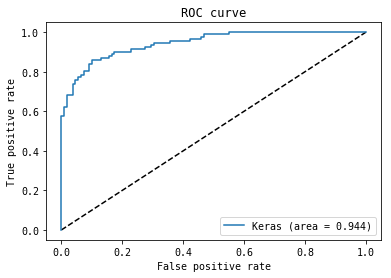

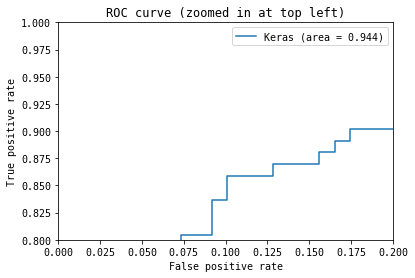

In [63]:
#Data for ROC
y_pred_keras = model.predict(X_test.iloc[:,0:51]).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)

auc_keras = auc(fpr_keras, tpr_keras)

#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')


In [64]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from runTournament import runTournament

df=pd.read_csv("tourney_game_master1.csv")
#2017 results
dfList, scoreDF=runTournament(df,2017,'model_3','model_3')
for df in dfList:
    print('\n',df)

scoreDF


                  ATeam              BTeam  ATeamID  BTeamID
0       mount-st-marys          villanova     1291     1437
1            wisconsin      virginia-tech     1458     1439
2       unc-wilmington           virginia     1423     1438
3              florida  east-tennessee-st     1196     1190
4                  usc                smu     1425     1374
5        new-mexico-st             baylor     1308     1124
6       south-carolina          marquette     1376     1266
7                 duke               troy     1181     1407
8      south-dakota-st            gonzaga     1355     1211
9           vanderbilt       northwestern     1435     1321
10           princeton         notre-dame     1343     1323
11            bucknell      west-virginia     1137     1452
12              xavier           maryland     1462     1268
13  florida-gulf-coast         florida-st     1195     1199
14                 vcu        saint-marys     1433     1388
15             arizona       north-dak

,round,score
0,32,29
1,16,24
2,8,24
3,4,16
4,2,0
5,1,0
6,Total,93


In [66]:
#2018 results
df=pd.read_csv("tourney_game_master1.csv")
dfList, scoreDF=runTournament(df,2018,'model_3','model_3')
for df in dfList:
    print('\n',df)

scoreDF


                     ATeam             BTeam  ATeamID  BTeamID
0               villanova           radford     1437     1347
1           virginia-tech           alabama     1439     1104
2               murray-st     west-virginia     1293     1452
3                marshall        wichita-st     1267     1455
4          st-bonaventure           florida     1382     1196
5              texas-tech  stephen-f-austin     1403     1372
6                  butler          arkansas     1139     1116
7        cal-st-fullerton            purdue     1168     1345
8                  kansas              penn     1242     1335
9       north-carolina-st        seton-hall     1301     1371
10                clemson     new-mexico-st     1155     1308
11  college-of-charleston            auburn     1158     1120
12                    tcu          syracuse     1395     1393
13            michigan-st          bucknell     1277     1137
14               oklahoma      rhode-island     1328     1348
15    

,round,score
0,32,29
1,16,22
2,8,16
3,4,16
4,2,16
5,1,32
6,Total,131


In [68]:
#2019 results
df=pd.read_csv("tourney_game_master1.csv")
dfList, scoreDF=runTournament(df,2019,'model_3','model_3')
for df in dfList:
    print('\n',df)

scoreDF



                 ATeam                BTeam  ATeamID  BTeamID
0     north-dakota-st                 duke     1295     1181
1                 vcu                  ucf     1433     1416
2      mississippi-st              liberty     1280     1251
3       virginia-tech          saint-louis     1439     1387
4            maryland              belmont     1268     1125
5                yale                  lsu     1463     1261
6           minnesota           louisville     1278     1257
7             bradley          michigan-st     1133     1277
8             gonzaga  fairleigh-dickinson     1211     1192
9            syracuse               baylor     1393     1124
10          marquette            murray-st     1266     1293
11            vermont           florida-st     1436     1199
12         arizona-st              buffalo     1113     1138
13         texas-tech    northern-kentucky     1403     1297
14            florida               nevada     1196     1305
15           michigan 

,round,score
0,32,28
1,16,30
2,8,32
3,4,24
4,2,16
5,1,32
6,Total,162


In [69]:
pastMadness

,Year,avg_score,higherSeed_score,myScore,percentile_myScore
0,2017,65.7,82,93,83.00
1,2018,57.0,81,131,99.20
2,2019,74.0,124,162,99.99
